<a href="https://colab.research.google.com/github/Vishal-ib97/Developer-Name-Disambiguation/blob/main/data_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import pandas as pd
import numpy as np
!pip install pyjarowinkler
import pyjarowinkler
from pyjarowinkler import distance
from collections import defaultdict
from numpy import linalg as LA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pd.set_option('display.max_rows', 100)

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#loading the commit data cohort and the info extracted from JSON file
f = pd.read_csv("/content/gdrive/MyDrive/GG_Project_NLP/Data/commit_messages/final_cleaned_10_updated_13dec_v3.csv")  #commit data
com = pd.read_csv("/content/gdrive/MyDrive/GG_Project_NLP/Data/commit_messages/json_data_updated_13dec_v3.csv")       #JSON file

In [59]:
f.shape

(657, 13)

### **Finding the full author names**

In [4]:
#Calculating the similarities projectwise
proj_dict = defaultdict()
project_groups = f.groupby('proj_name')
for proj in project_groups.groups:
  sim = defaultdict(list)
  for i in zip(f[f.proj_name == proj].author_name, f[f.proj_name == proj].email_id):
    if i not in sim:
      for j in zip(com[com.project == proj].author_name, com[com.project == proj].user_ids):
        if not pd.isnull(j[1]):
          if j not in sim[i]:
            a = distance.get_jaro_distance(i[0], j[0], winkler=False, scaling=0.8)
            b = distance.get_jaro_distance(i[0], j[1], winkler=False, scaling=0.8)
            c = distance.get_jaro_distance(i[1], j[0], winkler=False, scaling=0.8)
            d = distance.get_jaro_distance(i[1], j[1], winkler=False, scaling=0.8)
          sim_score = LA.norm([a, b, c, d], np.inf)
        else:
          if j not in sim[i]:
            a = distance.get_jaro_distance(i[0], j[0], winkler=False, scaling=0.8)
            c = distance.get_jaro_distance(i[1], j[0], winkler=False, scaling=0.8)
          sim_score = LA.norm([a, c], np.inf)
  
        sim[i].append((j, sim_score))
  proj_dict[proj] = sim

#getting the top k ranked names
def rank(poject, name, email, k):
  return sorted(proj_dict[poject][(name, email)], key = lambda x: x[1], reverse = True)[:k]

In [31]:
f

,Unnamed: 0,index,Unnamed: 0.1,Unnamed: 0.1.1,proj_name,date_time,author_name,email_id,from,actual name,actual email,add_json,Similar
0,0,0,0,0,accumulo,2020-12-03 14.03.00,christopher tubbs,ctubbsii,ctubb...@apache.org,christopher tubbs,ctubbsii,NaN,NaN
1,1,1,1,1,accumulo,2020-12-04 16.02.00,dave marion,dlmarion,dlmar...@apache.org,dave marion,dlmarion,NaN,NaN
2,2,2,2,2,accumulo,2020-11-02 15.14.00,mike miller,mmiller,mmil...@apache.org,mike miller,mmiller,NaN,NaN
3,3,3,3,3,accumulo,2020-11-03 17.39.00,keith turner,kturner,ktur...@apache.org,keith turner,kturner,NaN,NaN
4,4,4,4,4,accumulo,2020-11-04 18.25.00,jeffrey manno,jeffreymanno15,jma...@apache.org,jeffrey manno,jmanno,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,715,715,731,1001,wicket,2008-05-01 15.41.00,marrink,marrink,marr...@apache.org,maurice marrink,marrink,1.0,NaN
653,716,716,732,1002,archiva,2008-02-29 23.26.00,rinku,rinku,ri...@apache.org,rahul thakur,rinku,1.0,NaN
654,717,717,733,1003,subversion,2018-08-23 18.01.00,senthil kumaran s,sebb,s...@apache.org,senthil kumaran s,stylesen,NaN,NaN
655,718,718,735,1005,servicemix,2011-01-20 13.45.00,tobias soloschenko,thomas termin,tt...@apache.org,thomas termin,tterm,NaN,NaN


In [9]:
#calculating accuracy
c = 0
for i in zip(f.proj_name.values, f.author_name.values, f.email_id.values, f['actual name'].values):
  r = list(zip(*sorted(proj_dict[i[0]][(i[1], i[2])], key = lambda x: x[1], reverse = True)))[0]
  p = list(zip(*r))[0][:5]
  if i[3] in p:
    c += 1
    #print(i[0], "(", i[1], ",", i[2],")", i[3], p)
print(c)
print("Accuracy by checking the top", len(p), "matches : ", (c/len(f))*100)

652
Accuracy by checking the top 5 similar names :  99.23896499238964


In [32]:
rank("accumulo", "jeffrey manno", "jeffreymanno15", 3)

[(('jeffrey manno', 'jmanno'), 1.0),
 (('jeffrey s schwartz', nan), 0.7307692307692308),
 (('jeffrey zeiberg', nan), 0.7162393162393162)]

## **hidden ids**

In [15]:
final_m = pd.read_csv("/content/gdrive/MyDrive/GG_Project_NLP/Data/commit_messages/final_from_df_V3.csv")
final_m.dropna(inplace = True)
final_m.reset_index(inplace = True)
final_m.shape

(273, 6)

In [16]:
final_m

,index,Unnamed: 0,proj_name,from,from_ids,full_from_ids
0,0,0,accumulo,dlmar...@apache.org,dlmar,dlmarion
1,1,1,accumulo,jma...@apache.org,jma,jmanno
2,2,2,accumulo,ibe...@apache.org,ibe,ibella
3,3,3,accumulo,d...@apache.org,d,drew
4,4,4,accumulo,jmar...@apache.org,jmar,jmark99
...,...,...,...,...,...,...
268,270,270,wicket,marr...@apache.org,marr,marrink
269,271,271,archiva,ri...@apache.org,ri,rinku
270,272,272,subversion,s...@apache.org,s,stsp
271,273,273,servicemix,tt...@apache.org,tt,tterm


In [17]:
#calculating the similarities
hid_proj_dict = defaultdict()
project_groups = final_m.groupby('proj_name')
for proj in project_groups.groups:
  email_sim = defaultdict(list)
  for i in final_m.loc[final_m.proj_name == proj, 'from_ids'].unique():
    for k in com.loc[(com.project == proj) & (~com.user_ids.isna()), "user_ids"].unique():
      email_sim[i].append((k, distance.get_jaro_distance(i, k, winkler=False, scaling=0.8)))
  hid_proj_dict[proj] = email_sim

In [18]:
#Appending a column with the top k matches
fill = []
for num, i in enumerate(final_m.index):
  fill.append(list(list(zip(*sorted(hid_proj_dict[final_m.loc[i, 'proj_name']][final_m.loc[i, 'from_ids']], key = lambda x: x[1], reverse = True)))[0][:2]))
fill = pd.Series(fill)
final_m['filled_id'] = fill

In [22]:
#calculating the matches and accuracy
c = 0
for i in final_m.index:
  if final_m.loc[i, "full_from_ids"] in final_m.loc[i, "filled_id"]:
    c += 1
    #print(final_m.loc[i, :])
print("Accuracy by checking the top", len(final_m.filled_id[0]), "matches : ", (c/len(final_m))*100)

Accuracy by check the top 2 matches :  98.9010989010989


## **clustering**

In [27]:
#calculating the similarities and creating the similarity vectors for each pair of (author_name, email_id)
clust_proj_dict = defaultdict()
project_groups = f.groupby('proj_name')
for proj in project_groups.groups:
  sim = defaultdict(list)
  for i in zip(f[f.proj_name == proj].author_name, f[f.proj_name == proj].email_id):
    if i not in sim:
      for j in zip(com[com.project == proj].author_name, com[com.project == proj].user_ids):
        if not pd.isnull(j[1]):
          a = distance.get_jaro_distance(i[0], j[0], winkler=False, scaling=0.8)
          b = distance.get_jaro_distance(i[0], j[1], winkler=False, scaling=0.8)
          c = distance.get_jaro_distance(i[1], j[0], winkler=False, scaling=0.8)
          d = distance.get_jaro_distance(i[1], j[1], winkler=False, scaling=0.8)
          sim_score = LA.norm([a, b, c, d], np.inf)
        else:
          a = distance.get_jaro_distance(i[0], j[0], winkler=False, scaling=0.8)
          c = distance.get_jaro_distance(i[1], j[0], winkler=False, scaling=0.8)
          sim_score = LA.norm([a, c], np.inf)
  
        sim[i].append(sim_score)
  clust_proj_dict[proj] = sim

In [14]:
com[com.project == "accumulo"].author_name.nunique(), len(clust_proj_dict["accumulo"].keys())

(108, 151)

In [28]:
#Building the kmeans model for clustering
arr = np.array(list(clust_proj_dict["accumulo"].values()))
kmeans = KMeans(n_clusters = 108, random_state = 0).fit(arr)

In [29]:
np.array(list(clust_proj_dict["accumulo"].keys()))[list(kmeans.labels_ == 17)]

array([['bill slacum', 'bill'],
       ['william slacum', 'ujustgotbilld'],
       ['bill slacum', 'ujustgotbilld'],
       ['bill slacum', 'billslacum']], dtype='<U22')

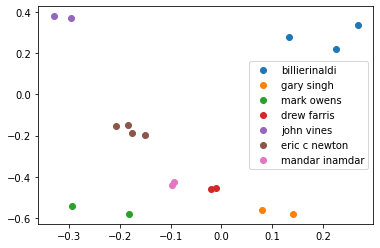

In [30]:
#Visualizing the clustering
pca = PCA(2)
arr_df = pca.fit_transform(arr)
names = [3, 6, 13, 20, 27, 35, 37]
for i in names:
  clust = arr_df[kmeans.labels_ == i]
  label = np.array(list(clust_proj_dict["accumulo"].keys()))[list(kmeans.labels_ == i)][0][0]
  plt.scatter(clust[:, 0], clust[:, 1], label = label)
#plt.xlim(-0.5, 0.6)
#plt.ylim(-0.6, 0.5)
plt.legend()